Runterladen von Bildern aus der Cloud

In [1]:
# installation of used package (for cloud connection)
!pip install boto3
import boto3
import os

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 6.7MB 4.8MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for boto3: filename=boto3-1.15.13-py2.py3-none-any.whl size=127861 sha256=0efb7d745471a93521ee8e8e8c90f55f52e5db5ac6b7a452ad71f39f42b90dbd
  Stored in directory: /root/.cache/pip/wheels/35/5a/eb/fe69289e84a5dddca3cceac736e265215b1eee4adc65c48c65
Successfully built boto3


In [2]:
cloud_access_key         = "minio"
cloud_secret_key         = "miniostorage"
cloud_bucket_name        = "dataset-v1-dih4cps"
cloud_url                = "https://minio.dih4cps.swms-cloud.com:9000/"

download_dir             = "."

# initialize cloud connection 
s3_client = boto3.client('s3',
                aws_access_key_id = cloud_access_key,
                aws_secret_access_key = cloud_secret_key,
                endpoint_url=cloud_url, 
                verify=False,
                config=boto3.session.Config(signature_version='s3v4'))
                
s3_resource = boto3.resource('s3',
                aws_access_key_id = cloud_access_key,
                aws_secret_access_key = cloud_secret_key,
                endpoint_url=cloud_url, 
                verify=False,
                config=boto3.session.Config(signature_version='s3v4'))

s3_bucket = s3_resource.Bucket(cloud_bucket_name)
path = ""
for bucket_object in s3_bucket.objects.all():
    object_name = str(bucket_object.key)
    if object_name.count("png") > 0:
        path = object_name
        s3_client.download_file(cloud_bucket_name, bucket_object.key, path)
    if object_name.count("xml") > 0:
        path = object_name.split("/")[1]
        s3_client.download_file(cloud_bucket_name, bucket_object.key, path)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Einladen der Bilder

In [3]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import *

In [4]:
classes = ["none", "shrimp"]

def convert_voc_annotation(image_dir, voc_filename):
  """
  source: https://github.com/rawar/ix-tut-yolov3/blob/master/notebooks/ix_objectdetect_tut1_02.ipynb
  """

  in_file = open(voc_filename)
  tree=ET.parse(in_file)
  root = tree.getroot()
  yolo_line = ""
  
  image_filename = voc_filename.split(".")[0]
  new_image_filename = image_dir + '/' + image_filename + '.png'

  for obj in root.iter('object'):
    difficult = obj.find('difficult').text
    cls = obj.find('name').text
    if cls not in classes or int(difficult)==1:
        continue
    cls_id = classes.index(cls)
    xmlbox = obj.find('bndbox')
    b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
    yolo_line = new_image_filename + " " + ",".join([str(a) for a in b]) + ',' + str(cls_id)

    return yolo_line

def load_data():
    annotation_file_paths = glob.glob("*.xml")
    inputdata = []      # x
    outputdata = []     # y
    for i, path in enumerate(annotation_file_paths):
        ## INPUT DATA
        # read image and save as RGB np array (float32)
        img_path = path.split(".")[0] + ".png"
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255
        inputdata.append(img)

        ## OUTPUT DATA
        if convert_voc_annotation(".", path) is None:
            outputdata.append(np.float32(0))
        else:
            outputdata.append(np.float32(1))
        outputdata[i] = outputdata[i].astype(np.float32)

    x_train, x_test, y_train, y_test = train_test_split(np.array(inputdata), 
                                                        np.array(outputdata), 
                                                        test_size=0.2, 
                                                        random_state=42)
    return (x_train, y_train), (x_test, y_test)


Beispielbilder anzeigen

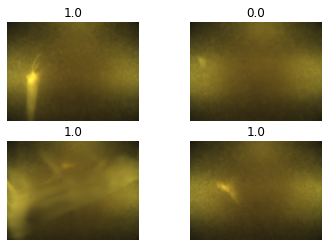

In [5]:
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# grid erzeugen
num_cols, num_rows = 2, 2
grid_list = []
image_list = []
for i in range(num_cols * num_rows):
    grid_list.append(plt.subplot(num_rows, num_cols,i + 1))
    image_list.append(grid_list[i].imshow(x_train[i]))
    grid_list[i].axis("off")
    grid_list[i].set_title(str(y_train[i]))
plt.show()

In [7]:
import os
# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Cast to np.float32
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Dataset variables
train_size = x_train.shape[0]
test_size = x_test.shape[0]
width, height, depth = x_train.shape[1:]
num_features = width * height * depth
num_classes = 2

# Compute the categorical classes_list
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Save Path
model_dir_path = os.path.abspath("./models")
if not os.path.exists(model_dir_path):
    os.mkdir(model_dir_path)
model_v1_path = os.path.join(model_dir_path, "modelv1.h5")
# Log Dir
log_dir_path = os.path.abspath("./logs/")
if not os.path.exists(log_dir_path):
    os.mkdir(log_dir_path)
model_log_dir_path = os.path.join(log_dir_path, "modelv1")

# Model params
lr = 0.001
optimizer = Adam(lr=lr)
epochs = 10
batch_size = 256

# Define the DNN
input_img = Input(shape=x_train.shape[1:])

x = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
x = Activation("relu")(x)
x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
x = Activation("relu")(x)
x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = Activation("relu")(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dense(units=128)(x)
x = Activation("relu")(x)
x = Dense(units=num_classes)(x)
y_pred = Activation("softmax")(x)

# Build the model
model = Model(inputs=[input_img], outputs=[y_pred])

# Compile and train (fit) the model, afterwards evaluate the model
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])
model.fit(
    x=x_train, 
    y=y_train, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test))

score = model.evaluate(
    x_test, 
    y_test, 
    verbose=0)
print("Score: ", score)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 480, 640, 32)      896       
_________________________________________________________________
activation_10 (Activation)   (None, 480, 640, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 480, 640, 32)      9248      
_________________________________________________________________
activation_11 (Activation)   (None, 480, 640, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 240, 320, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2457600)          

ResourceExhaustedError: ignored

In [ ]:
test_img = x_test[0]

y_pred = model.predict(test_img)
print(y_pred)